In [547]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import yfinance as yf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from Data_Retriever import DataRetriever as DatRet
from Markowitz_PT import MarkowitzPT as MPT

<h1> Stock pool </h1>

In [548]:
# Defining stock pool
ticker_df =  pd.DataFrame()
ticker_df["Petroleum"] = ["AKRBP.OL", "EQNR.OL", "ODL.OL"]
ticker_df["Materials"] = ["NHY.OL", "NSKOG.OL", "RANA.OL"]
ticker_df["Food"] = ["LSG.OL", "MOWI.OL", "ORK.OL"]
ticker_df

,Petroleum,Materials,Food
0,AKRBP.OL,NHY.OL,LSG.OL
1,EQNR.OL,NSKOG.OL,MOWI.OL
2,ODL.OL,RANA.OL,ORK.OL


In [549]:
# Retrieve data from yf API
data = DatRet(ticker_df, "2022-02-19", "2025-02-18")
data.retrieve_data()

# Generate benchmark weights thorugh MPT using Sharpe ratio
benchmark = MPT(data.returns, 252,10)
benchmark.frequency_optimizing()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--Frequency trading using MPT successfully performed--


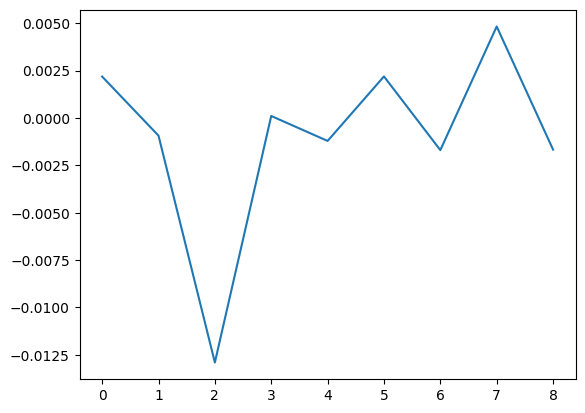

In [609]:
daily_returns = []
for time in range(1,10,1):
    ind_day_ret = np.array([data.returns[i][j].iloc[-time].iloc[0] for i in  range(3) for j in range(3)]) -1
    daily_returns.append(ind_day_ret[::])
daily_returns = daily_returns[::-1]

daily_ben_weights = benchmark.frequency_weights[:-1]
daily_ben_weights = np.array([benchmark.frequency_weights[i][0] for i in range(len(benchmark.frequency_weights))])[:-1]
daily_exp_weights = np.repeat(1/9,9)


# rl_perf = [daily_ben_weights[time]@daily_returns[time] for time in range(9)]
rl_perf = [sum(daily_ben_weights[time]*daily_returns[time]) for time in range(9)]

# mpt_perf = [daily_exp_weights@daily_returns[time] for time in range(9)]
mpt_perf = [sum(daily_exp_weights*daily_returns[time]) for time in range(9)]

# excess_ret = [(rl_perf[time]-mpt_perf[time])/rl_perf[time] for time in range(9)]
excess_ret = [rl_perf[time] - mpt_perf[time] for time in range(9)]

plt.plot(excess_ret)

In [ ]:
wb1 = np.sum(daily_ben_weights[0][:3])
we1 = np.sum(daily_exp_weights[:3])
rb1 = np.dot(daily_ben_weights[0][:3], daily_returns[0][:3])
re1 = np.dot(daily_exp_weights[:3], daily_returns[0][:3])

wb2 = np.sum(daily_ben_weights[0][3:6])
we2 = np.sum(daily_exp_weights[3:6])
rb2 = np.dot(daily_ben_weights[0][:3], daily_returns[0][3:6])
re2 = np.dot(daily_exp_weights[:3], daily_returns[0][3:6])


wb3 = np.sum(daily_ben_weights[0][6:9])
we3 = np.sum(daily_exp_weights[6:9])
rb3 = np.dot(daily_ben_weights[0][:3], daily_returns[0][6:9])
re3 = np.dot(daily_exp_weights[:3], daily_returns[0][6:9])

ae1 = rb1*(we1-wb1)
se1 = wb1*(re1-rb1)
ie1 = (we1-wb1)*(re1-rb1)
a = ae1+se1+ie1

ae2 = rb2*(we2-wb2)
se2 = wb2*(re2-rb2)
ie2 = (we2-wb2)*(re2-rb2)
b = ae2+se2+ie2

ae3 = rb3*(we3-wb3)
se3 = wb3*(re3-rb3)
ie3 = (we3-wb3)*(re3-rb3)
c = ae3+se3+ie3

delta = (a+b+c)*100+1

In [582]:
# ae1 = rb1 * (we1 - wb1)  # Allocation Effect
# se1 = wb1 * (re1 - rb1)  # Selection Effect
# ie1 = (we1 - wb1) * (re1 - rb1)  # Interaction Effect

# print(f"Sector 1: AE={ae1}, SE={se1}, IE={ie1}")
# print(f"Sector 2: AE={ae2}, SE={se2}, IE={ie2}")
# print(f"Sector 3: AE={ae3}, SE={se3}, IE={ie3}")



In [601]:
print(np.sum(daily_ben_weights, axis=1))  # Should be 1 for each day
print(np.sum(daily_exp_weights))  # Should be 1


[1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


In [613]:
delta-1 -excess_ret[0]

np.float64(-0.010874336430036532)

In [610]:
excess_ret

[np.float64(0.002186917189325053),
 np.float64(-0.0009315807590682405),
 np.float64(-0.01290334818632083),
 np.float64(0.00010663477764632535),
 np.float64(-0.001211006575115513),
 np.float64(0.0021932599527938485),
 np.float64(-0.0016953982008076456),
 np.float64(0.0048300376095121115),
 np.float64(-0.0016668999632444834)]

In [ ]:
class BHBAnalyzer():
    
    def __init__(self, 
                 benchmark_data=None,
                 experiment_data=None,
                 raw_data=None
                 ):
        """
        Args:
            benchmark_data: NxM list from MPT
            experiment_data: NxM list from RL    
        """
        self.benchmark_data =  benchmark_data
        self.experiment_data = experiment_data
        self.raw_data = raw_data

    def frequency_analyze():
        pass